In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
pickle_file = 'number_ocr.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (385150, 32, 32), (385150,))
('Validation set', (6000, 32, 32), (6000,))
('Test set', (26032, 32, 32), (26032,))


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 32
label_num_start = 1
label_num_stop = 10
num_channels = 1 # grayscale


def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(label_num_start, label_num_stop + 1) == 
                labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (385150, 32, 32, 1), (385150, 10))
('Validation set', (6000, 32, 32, 1), (6000, 10))
('Test set', (26032, 32, 32, 1), (26032, 10))


In [4]:
# data check
train_labels[:5]

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)

In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [61]:
batch_size = 16 #64
patch_size = 5
depth = 32 #16
depth2 = 64
num_hidden = 512 #64
num_labels = 10

graph = tf.Graph()



with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset) 
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
  
    # Model.
    def model(data, train=False):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, 
                             ksize=[1,2,2,1],
                             strides=[1,2,2,1],
                             padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.5) 
        final = tf.matmul(hidden, layer4_weights) + layer4_biases
        return hidden, layer4_weights, layer4_biases, final
  
    # Training computation.
    _, _, _, logits = model(tf_train_dataset, train=True)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(layer3_weights) +
                      tf.nn.l2_loss(layer4_weights))
    # Add the regularization term to the loss.
    loss += 0.001 * regularizers

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step,
            15000,0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    _, _, _, v_data = model(tf_valid_dataset)
    valid_prediction = tf.nn.softmax(v_data)
    x, W, b, t_data = model(tf_test_dataset)
    test_prediction = tf.nn.softmax(t_data)
    
    # My dataset
    my_dataset = test_dataset[0:16]
    tf_my_dataset = tf.constant(my_dataset)
    _, _, _, my_data = model(tf_my_dataset)
    my_prediction = tf.nn.softmax(my_data)


In [77]:
num_steps = 25001
#100001 = 92.5%
#75001 = 
#50001 = 90.5-91.2% about 2 mins


start_time = time.time()
#init = tf.initialize_all_variables()
#sess = tf.Session()
#sess.run(init)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print 'Initialized'
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 5000 == 0):
            print 'Minibatch loss at step %d: %f' % (step, l)
            print 'Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels)
            print 'Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels)
    print 'Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels)
    my_pred_arr = my_prediction.eval()
print '\nElapsed time:', time.time() - start_time

Initialized
Minibatch loss at step 0: 14.107420
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 5000: 5.536198
Minibatch accuracy: 81.2%
Validation accuracy: 84.5%
Minibatch loss at step 10000: 3.292893
Minibatch accuracy: 87.5%
Validation accuracy: 87.0%
Minibatch loss at step 15000: 2.087745
Minibatch accuracy: 93.8%
Validation accuracy: 88.7%
Minibatch loss at step 20000: 2.055004
Minibatch accuracy: 87.5%
Validation accuracy: 89.7%
Minibatch loss at step 25000: 0.873910
Minibatch accuracy: 100.0%
Validation accuracy: 90.6%
Test accuracy: 89.7%

Elapsed time: 104.621119976


In [94]:
predicted_labels = []
for i in range(len(my_pred_arr)):
    predicted_labels.append(np.argmax(my_pred_arr[i])+1)
print 'Predicted labels:', predicted_labels

actual_labels = []
my_labels = test_labels[0:16]
for i in range(len(my_labels)):
    actual_labels.append(np.argmax(my_labels[i])+1)
print 'Actual labels:   ', actual_labels

Predicted labels: [1, 2, 4, 1, 8, 7, 2, 5, 10, 3, 9, 3, 8, 9, 6, 5]
Actual labels:    [1, 2, 4, 1, 8, 1, 2, 5, 10, 2, 9, 3, 8, 9, 6, 8]


(16, 32, 32)


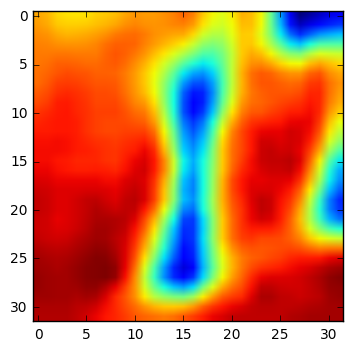

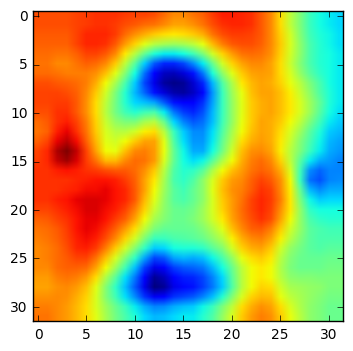

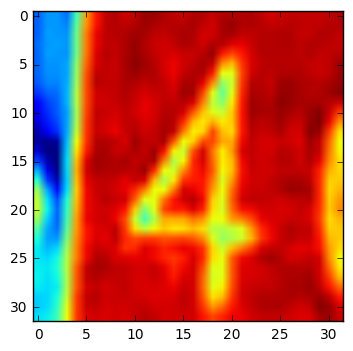

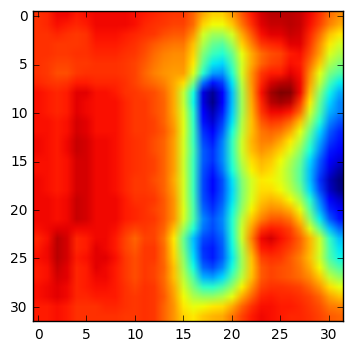

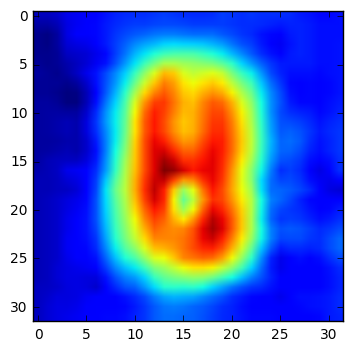

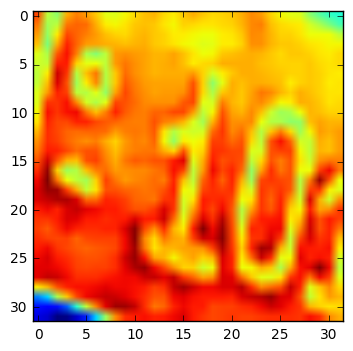

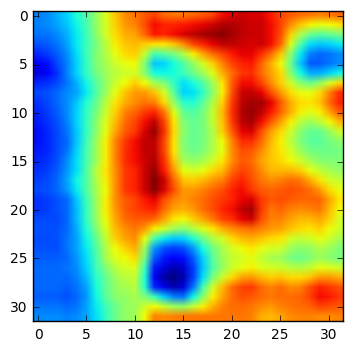

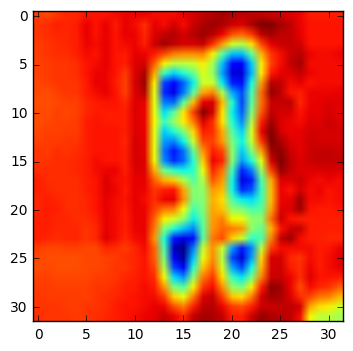

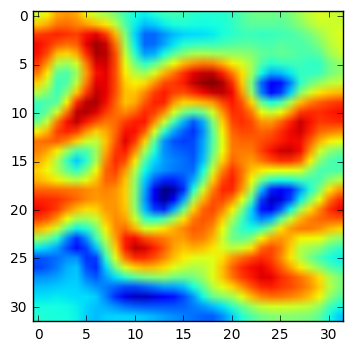

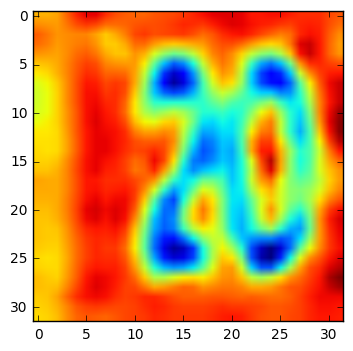

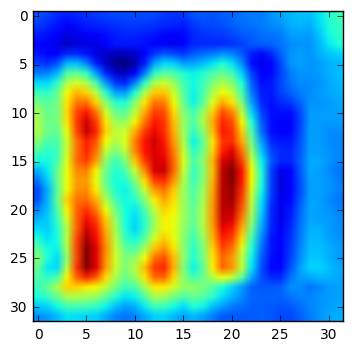

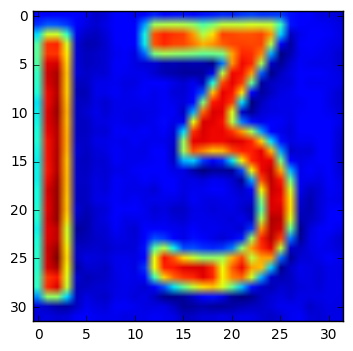

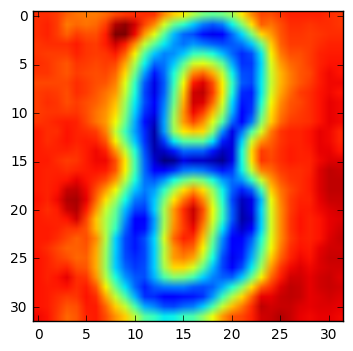

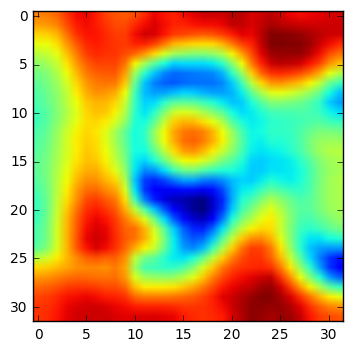

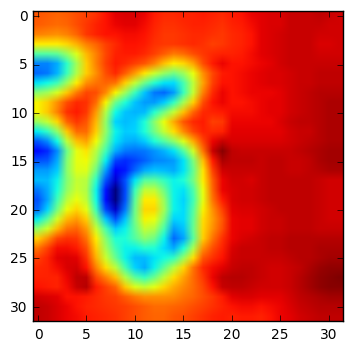

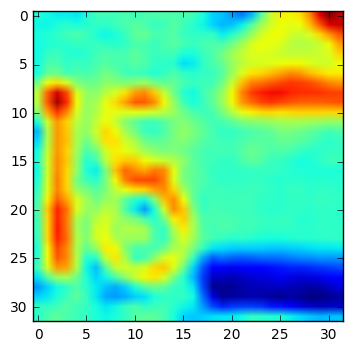

In [88]:
try_dataset = np.reshape(my_dataset, (len(my_dataset), 32, 32))
print try_dataset.shape
for pic in range(len(try_dataset)):
    pic_print = try_dataset[pic]
    plt.imshow(pic_print)
    plt.show()
